> Version: 1.0 \
> Time: August, 2022 \
> Author: by XunYang, TLab, Southeast University

Toy Horizontal Route:
  - Alignment sequence: (C1-B2-A3-B4-C5) (circilar curve, transition curve, straight line, transition curve, straight curve)
  - Length: (150m, 100m, 300m, 100m, 150m)
  - Curvature: (1/400, 1/400-0, 0, 0-1/400, 1/400)
  - Direction: (left, left, forward, right, right)


>> i. Toy Horizontal Route in SUMO

In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

In [2]:
# ToyRoute Information

from Tools.toyRoute import ToyRouteInfor

L = [150, 100, 300, 100, 150] # Length
A = ['C', 'B', 'A', 'B', 'C'] # Alignment Type
R = 400 # Radius
ToyRouteInformation = ToyRouteInfor(L, R) # Information

In [3]:
ToyRouteInformation.keys()

dict_keys(['junction', 'nodex', 'nodey', 'curvature', 'section'])

In [4]:
junction = ToyRouteInformation['junction']
nodex = ToyRouteInformation['nodex']
nodey = ToyRouteInformation['nodey']
curvature = ToyRouteInformation['curvature']
section = ToyRouteInformation['section']

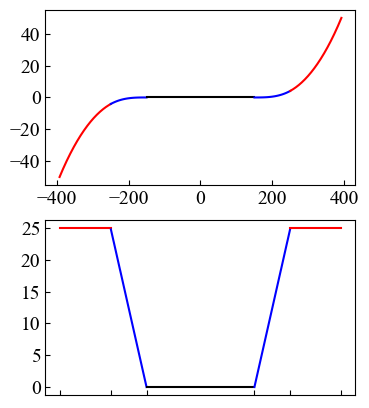

In [16]:
plt.figure(figsize=(4,5))
plt.subplot(2,1,1)


plt.rcParams["font.family"] = "Times New Roman"
color=['red', 'blue', 'black', 'blue', 'red']
for i in range(5):
    x = section['section%d'%(i+1)]['x']
    y = section['section%d'%(i+1)]['y']
    plt.plot(x, y, color=color[i])
plt.tick_params(axis='both', direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(2,1,2)

color=['red', 'blue', 'black', 'blue', 'red']
ix, iy = 0, 0
for i in range(5):
    x = section['section%d'%(i+1)]['x']
    y = section['section%d'%(i+1)]['y']
    
    plt.plot(nodex[ix:ix+len(x)], curvature[iy:iy+len(y)], color=color[i])
    ix += len(x)
    iy += len(y)
    
plt.xticks([-391.7, -249.8, -150.0, 150.0, 249.84375, 391.74407], ['', '', '', '', '', ''], fontsize=12)
plt.yticks([0, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025], ['0', '5', '10','15','20', '25'], fontsize=12)
plt.yticks(fontsize=14)
#plt.ylabel('Curvature ($×10^{-4}$)', fontsize=14)|
#plt.ylabel('Curvature ($×10^{-4}$)', fontsize=14)
plt.tick_params(axis='both', direction='in')
plt.savefig('ToyRoute.png', bbox_inches='tight', dpi=1000)

In [12]:
junction

[[-391.74407208759015, -50.00805850463013],
 [-249.84375, -4.1620163690476195],
 [-150.0, 0],
 [150.0, 0],
 [249.84375, 4.1620163690476195],
 [391.74407208759015, 50.00805850463013]]

In [6]:
## generate Node file: ToyRoute.nod.xml
with open('SUMORoute/ToyRoute.nod.xml', 'w') as f:
    f.write('<nodes>\n')
    for i in range(len(junction)):
        junction_node = junction[i]  
        x = junction_node[0]
        y = junction_node[1]
        f.write('    <node id="node%d" x="%f" y="%f" type="priority"/>\n'%(i, x, y))
    f.write('</nodes>\n')
    f.close()

In [7]:
## generate Edge file: ToyRoute.edg.xml

sections = ToyRouteInformation['section']

with open('SUMORoute/ToyRoute.edg.xml', 'w') as f:

    f.write('<edges>\n')
    for i in range(len(L)):
        length, alignment = L[i], A[i]
        f.write('    <edge id="%s%d" from="node%d" to="node%d" priority="1">\n'%(alignment, i+1, i, i+1))
        coordinates = sections['section%d'%(i+1)]
        x_list, y_list = coordinates['x'], coordinates['y']
        shape = ''
        for k in range(len(x_list)):
            shape += '%f,%f '%(x_list[k], y_list[k])
        f.write('        <lane index="0" speed="%f" length="%d" shape="%s"/>\n'%(120/3.6, length, shape))
        f.write('    </edge>\n')
    f.write('</edges>\n')
    
    f.close()

In [8]:
## generate Net file: ToyRoute.net.xml
os.system('%SUMO_HOME%/bin/netconvert \
            --node-files=SUMORoute/ToyRoute.nod.xml \
            --edge-files=SUMORoute/ToyRoute.edg.xml \
            --output-file=SUMORoute/ToyRoute.net.xml')

0

>> ii. Horizontal Alignment Data 

In [9]:
AlignmentInfor = {
    'RoadSectionOrder': [1, 2, 3, 4, 5],
    'AlignmentType': ['C', 'B', 'A', 'B', 'C'],
    'Length': [150, 100, 300, 100, 150],
    'CurvatureConstant': [1/400, 1/400, 0, 1/400, 1/400],
    'DirectionMark': ['-1', 'in', '-1', 'out', '-1']}
AlignmentInfor = pd.DataFrame(AlignmentInfor)
AlignmentInfor.to_csv('SUMOData/Alignment.csv')

>> iii. Trajectory data

In [10]:
## generate traffic flow: ToyRoute.rou.xml
import random

random.seed(1)

with open('SUMORoute/ToyRoute.rou.xml', 'w') as f:

    f.write('<routes>\n')
    f.write('    <vType id="car" accel="0.8" decel="4.5" sigma="0.1" length="5" maxSpeed="33.333" minGap="5" speedDev="0.1"/>\n')
    f.write('    <route id="route0" edges="C1 B2 A3 B4 C5"/>\n')
    id = 1
    for i in range(600):
        if random.random() <= 1/3:
            f.write('    <vehicle id="%d" type="car" route="route0" depart="%d" departSpeed="%f"/>\n'%(id, i, 20 + np.random.normal(0, 1.5, 1)))
            id += 1
        else:
            continue
    
    f.write('</routes>\n')
    f.close()

In [11]:
## generate trajectory data: roughdata

import os 
import sys
 
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

import traci

random.seed(1)

def RunSimulation():
    roughdata = []
    for i in range(600):
        traci.simulationStep()
        vehicle_id = traci.vehicle.getIDList()
        for id in vehicle_id:
            time_ = i + 1
            id_ = int(id.split('.')[-1])
            velocity_ = traci.vehicle.getSpeed(id)
            pile_ = traci.vehicle.getDistance(id)
            acceleration_ = traci.vehicle.getAcceleration(id)
            
            roughdata.append([id_, time_, velocity_, pile_, acceleration_])

    traci.close()

    return roughdata

traci.start(["sumo", "-c", "SUMORoute/ToyRoute.sumocfg", "--start"])
roughdata = RunSimulation()
roughdata = pd.DataFrame(roughdata, columns=['id', 'time', 'velocity', 'pile', 'acceleration'])

In [12]:
AlignmentInfor = pd.read_csv('SUMOData/Alignment.csv', index_col=0)

In [13]:
AlignmentInfor

,RoadSectionOrder,AlignmentType,Length,CurvatureConstant,DirectionMark
0,1,C,150,0.0025,-1
1,2,B,100,0.0025,in
2,3,A,300,0.0000,-1
3,4,B,100,0.0025,out
4,5,C,150,0.0025,-1


In [14]:
## processing trajectory data
from bisect import bisect_left

def get_loc(x, L):
    loc = bisect_left(L, x)
    if loc == 0:
        return loc + 1
    else:
        return loc

Length = [0] + list(AlignmentInfor['Length'])
Lengthslice = [sum(Length[:i+1]) for i in range(len(Length))]
RoadSection, Distance, Remain = [], [], []
for i in range(roughdata.shape[0]):
    kilo = roughdata['pile'].iloc[i]
    loc = get_loc(kilo, Lengthslice)
    location = AlignmentInfor['AlignmentType'].iloc[loc-1]
    order = AlignmentInfor['RoadSectionOrder'].iloc[loc-1]
    length = AlignmentInfor['Length'].iloc[loc-1]
    distance = kilo - Lengthslice[loc-1] 
    remain = Lengthslice[loc] - kilo
    RoadSection.append(location + str(order))
    Distance.append(distance)
    Remain.append(remain)
    
roughdata['roadsection'] = RoadSection
roughdata['distance'] = Distance
roughdata['remain'] = Remain

roughdata = roughdata.sort_values(by=['id', 'time'])

roughdata.to_csv('SUMOData/Trajectory.csv')